# BAIT 509: Business Applications of Machine Learning
## Lecture 4 - Feature pre-processing
Tomas Beuzen, 15th January 2020

# Lecture outline
- [0. Recap (5 mins)](#0)
- [1. Lecture learning objectives](#1)
- [2. Numeric feature normalization/standardization (30 mins)](#2)
- [3. Revisiting the Golden Rule (15 mins)](#3)
- [--- Break --- (10 mins)](#break)
- [4. Handling categorical data (15 mins)](#4)
- [5. Class Exercise: feature pre-processing (20 mins)](#5)
- [6. What we've learned today (5 mins)](#6)
- [7. Summary questions to ponder](#7)

# Announcements

- Assignment 1 due **11:59pm on Monday (20th Jan)**.
- I have office hours **1-2pm** on Monday in ESB1045.
- All marked in attendance on Wednesday and I won't take attendance today.

# 0. Recap  (5 mins) <a id=0></a>

- Cross-validation as a way of efficiently combining training/validation and choosing hyperparameters
- The kNN algorithm for classification and regression
- Lowess/loess smoothing 

# 1. Lecture learning objectives <a id=1></a>

- Describe the difference between normalising and standardising and be able to use scikit-learn's `MinMaxScaler()` and `StandardScaler()` to pre-process numeric features.
- Idenitfy when to implement pre-processing techniques like standardization in a machine learning model development pipeline.
- Describe the difference between label encoding and one hot encoding for converting categorical features to numeric values.
- Use the scikit-learn `ColumnTransformer` function to implement preprocessing functions such as `MinMaxScaler` and `OneHotEncoder` to numeric and categorical features simultaneously.

# 2. Numeric feature normalization/standardization (30 mins) <a id=2></a>
- Up to this point I've given you nice, clean data to build models from
- Of course, this is rarely the case in the real world
- One problem that comes up a lot is working with data of different scales/units
- For example, you might want to predict a person's height (cm) based on their age (years) and weight (kg). Obviously age and weight are completely different scales. Can this affect our ML models?
- Let's find out...
- The next two cells load in some necessary libraries for this lecture, plus the cities dataset we've been working with

In [1]:
# Load in the necessary packes for this notebook
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import sys
sys.path.append('code/')
from model_plotting import plot_model

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

- Let's create a kNN classifier on this data and find the error rate on the training and testing data

In [3]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print(f'Train error = {1 - knn.score(X_train, y_train):.2f}')
print(f'Test error = {1 - knn.score(X_test, y_test):.2f}')

Train error = 0.00
Test error = 0.07


- In this dataset, we are working with latitude and longitude which are on reasonably similar scales
- But what happens if we increase the `lon` feature by a factor of 1000?
- The code below does just this

In [4]:
X_train2 = X_train.copy()
X_train2['lon'] *= 1000
X_test2 = X_test.copy()
X_test2['lon'] *= 1000

In [5]:
X_train2.head()

,lon,lat
179,-76959.802,39.121343
253,-74091.296,40.904928
7,-81859.447,26.707947
275,-88128.107,41.541468
126,-76370.661,37.477066


- Now let's find the train and test error again...

In [6]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train2, y_train)
print(f'Train error = {1 - knn.score(X_train2, y_train):.2f}')
print(f'Test error = {1 - knn.score(X_test2, y_test):.2f}')

Train error = 0.00
Test error = 0.28


- Wow! We are doing much worse now. What has happened?
- Answer: recall that kNN is a distance based algorithm, the `lat` feature is now being ignored because it is on a much smaller scale than `lon`.
- Let's prove that by dropping the `lat` feature from our data and retraining a model.

In [7]:
X_train3 = X_train2.drop(columns=['lat']).copy()
X_test3 = X_test2.drop(columns=['lat']).copy()
X_train3.head()

,lon
179,-76959.802
253,-74091.296
7,-81859.447
275,-88128.107
126,-76370.661


In [8]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train3, y_train)
print(f'Train error = {1 - knn.score(X_train3, y_train):.2f}')
print(f'Test error = {1 - knn.score(X_test3, y_test):.2f}')

Train error = 0.00
Test error = 0.28


- We get the exact same error rate even though we just threw away one of our features!
- What is happening is that any variability in `lat` is "drowned out" by the variability in `lon` (after we've multiplied by 1000)

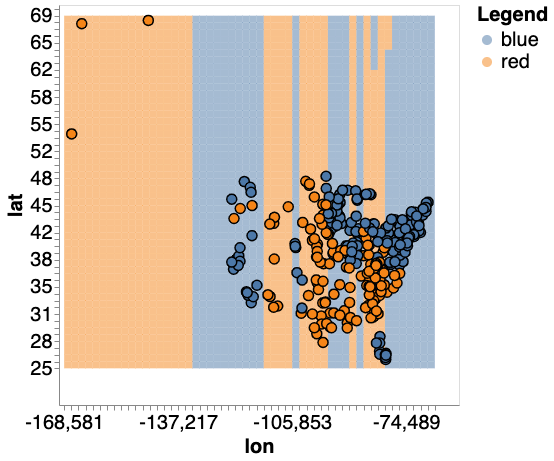

In [9]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train2, y_train)
plot_model(X_train2, y_train, knn).interactive()

## Normalization/standardization
- Here, we artifically changed the scale of our features
- But in practice, scaling issues are extremely common
- Two approaches to handle scale issues are:
    1. normalization
    2. standardization

| Approach | What it does | sklearn implementation | 
|---------|------------|----------------|
| normalization | sets range to $[0,1]$   |  [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets mean to $0$, s.d. to $1$   | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

- Let's use normalization to correct our (artificially created) scaling issue in the cities data
- Scaling functions in sklearn are similar to models, except instead of `.fit()` and `.predict()`, they have `.fit()` and `.transform()`
- The idea is calculate the necessary data statistics (e.g., mean, s.d., max, min, etc) in the `.fit()` stage, and then use these statistics to scale/transform the data in the `.transform()` stage.
- Recall that this is what our data looks like before normalizing:

In [10]:
X_train2.head()

,lon,lat
179,-76959.802,39.121343
253,-74091.296,40.904928
7,-81859.447,26.707947
275,-88128.107,41.541468
126,-76370.661,37.477066


- We will now use `MinMaxScaler` to normalize the data with the code below

In [11]:
from sklearn.preprocessing import MinMaxScaler # import the function
scaler = MinMaxScaler() # instantiate a class
scaler.fit(X_train2) # fit the scaler to the data
X_train2_scaled = scaler.transform(X_train2) # use the scaler to transform the data
X_test2_scaled = scaler.transform(X_test2)

- By default, sklearn scaling methods return a numpy array
- This is no problem as arrays can be used with sklearn models as well
- But they aren't as visually nice to look at, so in the code below I'm going to coerce the array back into a dataframe so we can see what the data looks like after scaling

In [12]:
pd.DataFrame(X_train2_scaled,
             columns=X_train2.columns,
             index=X_train2.index).head()

,lon,lat
179,0.913765,0.316837
253,0.943032,0.358918
7,0.863775,0.023967
275,0.799817,0.373935
126,0.919776,0.278044


- Okay let's see if scaling fixed our error problem

In [13]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train2_scaled, y_train)
print(f'Train error = {1 - knn.score(X_train2_scaled, y_train):.2f}')
print(f'Test error = {1 - knn.score(X_test2_scaled, y_test):.2f}')

Train error = 0.00
Test error = 0.06


- Great! Scaling allowed us to put our features on a common scale and we have now improved our error!

# 3. Revisiting the Golden Rule (15 mins) <a id=3></a>
- You might have noticed above that when I was scaling, I fit my scaler to the training data, and then used it to transform both the training data and testing data
- This was no mistake!
- Recall that the golden rule says that we should not use any information from our test data to build our model
- This includes scaling (and other data transformations!)
- It might help to look at the two ways you could scale data that are **wrong**

## Bad methodology 1: scaling datasets separately
- You should not scale your train data and test data separately
- This could result in you scaling them using different scales
- If you do this, how could you expect a model trained on data scaled one way, to predict data scaled in another?!
- In code (this time we will use `StandardScaler`):

In [14]:
from sklearn.preprocessing import StandardScaler
# first, scale the training data
scaler = StandardScaler()
scaler.fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
# now, scale the test data
scaler = StandardScaler() # BAD!!!
scaler.fit(X_test2) # NO! MY EYES! DONT DO IT!
X_test2_scaled = scaler.transform(X_test2) # NOOOOOOOOOOOOOOO
# print the model error
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train2_scaled, y_train)
print(f"Training score: {1 - knn.score(X_train2_scaled, y_train):.2f}")
print(f"Test score: {1 - knn.score(X_test2_scaled, y_test):.2f}")

Training score: 0.00
Test score: 0.11


- Notice that our error rate is a little worse!

## Bad methodology 2: scaling datasets together
- You should not scale your train data and test data together before splitting your data
- This would mean that you are using data from your (future) test set, to help you scale, thus violating the golden rule
- In code:

In [15]:
# let's load the data from scratch
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
# first, scale the training data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# now split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)
# print the model error
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print(f"Training score: {1 - knn.score(X_train, y_train):.2f}")
print(f"Test score: {1 - knn.score(X_test, y_test):.2f}")

Training score: 0.00
Test score: 0.06


- In this case we actually do a little better and that's because our model has already "seen" some information from the test dataset which can bias it to perform well

## Right methodology: scaling based on training data only
- Just to be 100% clear, what we need to do is fit our scaler to our training data only, and then use that scaler to transform both the training and testing data
- In this way, we are only using information in our train set to transform our data
- In code:

In [8]:
# let's load the data from scratch
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]
# first we split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.2,
                                                    random_state=123)
# first, scale the training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# print the model error
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print(f"Training score: {1 - knn.score(X_train, y_train):.2f}")
print(f"Test score: {1 - knn.score(X_test, y_test):.2f}")

Training score: 0.00
Test score: 0.06


# -------- Break (10 mins) -------- <a id="break"></a>

# 4. Handling categorical data (20 mins) <a id=4></a>

- In sklearn, most ML algorithms require numeric inputs
- That means we have to convert categorical data to numeric values
- There are two main ways of doing this:
    1. Label encoding
    2. One-hot encoding

- These methods are best demonstrated by example
- Let's make up some data to see these transformations in action

In [17]:
df = pd.DataFrame(["cat", "dog", "cat", "fish"], columns=['animal'])
df

,animal
0,cat
1,dog
2,cat
3,fish


## Label encoding
- Here we simply assign an integer to each of our unique categorical labels
- We can use sklearn's [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to help us do this

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
df['animal_encoded'] = le.fit_transform(df['animal'])
df

,animal,animal_encoded
0,cat,0
1,dog,1
2,cat,0
3,fish,2


- Well that was easy, but can you see a big problem with this approach???
- We have imposed ordinality on our categorical data
- For example, we are now saying that `fish (2)` is "closer" to `dog (1)` than to `cat (0)`
- This can be problematic (especially in distance-based algorithms such as kNN) because this ordinality doesn't actually make sense!
- In general, label encoding is only useful if there really is ordinality in your data, e.g., `[cold, warm, hot]`

## OHE (one-hot encoding)
- Rather than assign integer labes to our data, we can create a new binary columns to represent each of our categories
- If we have *n* categories, we create *n* new binary columns to represent those categories
- We can use sklearn's [OneHotEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do this

In [20]:
from sklearn.preprocessing import OneHotEncoder

- As I mentioned earlier, the transformer methods of sklearn typically return a numpy array (even if we pass in a pandas dataframe)
- So the code below looks complicated, but all I'm doing is coercing the result of `OneHotEncoder` back to a dataframe

In [21]:
df = pd.DataFrame(["cat", "dog", "cat", "fish"], columns=['animal'])
ohe = OneHotEncoder(sparse=False, dtype=int)
pd.concat((df, pd.DataFrame(ohe.fit_transform(df[['animal']]),
                            columns=ohe.categories_[0])),
          axis=1).head()

,animal,cat,dog,fish
0,cat,1,0,0
1,dog,0,1,0
2,cat,1,0,0
3,fish,0,0,1


- Now we see that we have a unique column for each category
- This solves our ordinality problem from before
- OHE is the typical approach used to transform categorical data into numeric data in practice
- However, you might be able to see that we actually only need $n-1$ new columns to encode $n$ categories...
- This is sometimes referred to as *dummy* encoding
- We can specify this in `OneHotEncoder()` by using the argument `drop='first'`
- In the dataframe below, `cat` is represented inherently when there is a 0 in `dog` and in `fish`

In [22]:
ohe = OneHotEncoder(drop='first', sparse=False, dtype=int)
pd.concat((df, pd.DataFrame(ohe.fit_transform(df[['animal']]),
                            columns=ohe.categories_[0][1:])),
          axis=1).head()

,animal,dog,fish
0,cat,0,0
1,dog,1,0
2,cat,0,0
3,fish,0,1


# 5. Class Exercise: feature pre-processing (20 mins) <a id=5></a>

In this class exercise we will practice using the pre-processing techniques we've learned in this lecture. We are going to use a real binary classification dataset of breast-cancer (read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)). The code below will load the dataset for you and split it into features (X) and the target (y). The features describe characteristics of cell nuclei in images of breast tissue - the features names canbe accessed using `dataset.feature_names` and you can read more about them [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). The target here is binary and composed of 0 (no breast cancer) and 1 (breast cancer).

Your tasks:

1. Split the dataset into 2 parts using `train_test_split()`: 80% training, 20% testing.
2. Fit a kNN classifier using the training data (using a `k=15`).
3. Calculate the error of your model on the test data.
4. Now, use `StandardScaler` to standardize your feature data (note that all attributes are numeric).
5. Refit your model and calculate the error once more. Did your result improve?
6. (Bonus) repeat the above but using a DecisionTreeClassifier (use a `max_depth` of your choosing but specify `random_state=123` to negate the effect of randomness in the tree). Does scaling affect your result now? Is this surprising?

In [6]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target.astype(int)

In [8]:
# 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# 2/3
knn = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
dt = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)
print(f'No scaling test score for kNN = {1 - knn.score(X_test, y_test):.2f}')
print(f'No scaling test score for dt = {1 - dt.score(X_test, y_test):.2f}')
# 4/5
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
# 6
dt = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)
print(f'Scaling test score = {1 - knn.score(X_test, y_test):.2f}')
print(f'Scaling test score for dt = {1 - dt.score(X_test, y_test):.2f}')

No scaling test score for kNN = 0.06
No scaling test score for dt = 0.04
Scaling test score = 0.03
Scaling test score for dt = 0.04


# 6. What we've learned today <a id="6"></a>

- The problems of having numeric data on different scales
- Scaling numeric data (normalization, standardization)
- How to properly implement scaling in a ML workflow
- Encoding categorical data

# 7. Questions to ponder <a id="7"></a>

1. What are some other common ML algorithms apart from kNN and decision trees?
2. Are some algorithms better at handling categorical data than others?